到目前为止，你已经了解了一个反向传播的简单示例。通过链式法则向后传播导数，可以计算复合函数（模型函数和损失函数）相对于它们的最内层参数w和b的梯度。基本的要求是涉及到的函数都是可微分的。在这种情况下，你可以通过一次扫描得到梯度（之前称为“损失变化率”）值。

在面对复杂的模型时，只要模型是可微的。通过一个名为**autograd的PyTorch模块来解决反向传播问题**。PyTorch张量可以记住它们来自什么运算以及其起源的父张量，并且提供相对于输入的导数链。你无需手动对模型求导：**不管如何嵌套，只要你给出前向传播表达式，PyTorch都会自动提供该表达式相对于其输入参数的梯度**。

---

### autograd模块重写之前温度校准时求导函数

In [352]:
import torch

In [353]:
# 数据集
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
    # t_c是摄氏度数，t_u是未知单位度数。
# 转化为张量
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [354]:
# 首先，模型和损失函数的定义如下
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [355]:
# 然后，初始化权置参数
    # 注意参数 requires_grad=True 
        # 这个参数告诉PyTorch需要追踪在params上进行运算而产生的所有张量.
params = torch.tensor([1.0,0], requires_grad=True)

In [281]:
# 对损失张量调用反向传播即可得到grad
loss = loss_fn(model(t_u,w=params[0],b=params[1]), t_c) 
    # 得到损失张量(loss_fn())。期间，在前向传播(model())的同时跟踪了这些张量。
loss.backward() #对损失张量调用反向传播backward()

# grad
params.grad

tensor([4517.2969,   82.6000])

### 本例中，params的grad属性包含损失关于params的每个元素的导数

你可以将包含任意数量的张量的require_grad设置为True以及组合任何函数。在这种情况下，PyTorch会在沿着整个函数链（即计算图）计算损失的导数，并在这些张量（即计算图的叶节点）的grad属性中将这些**导数值累积（accumulate）**起来

(是积累（accumulate）而不是存储（store）)

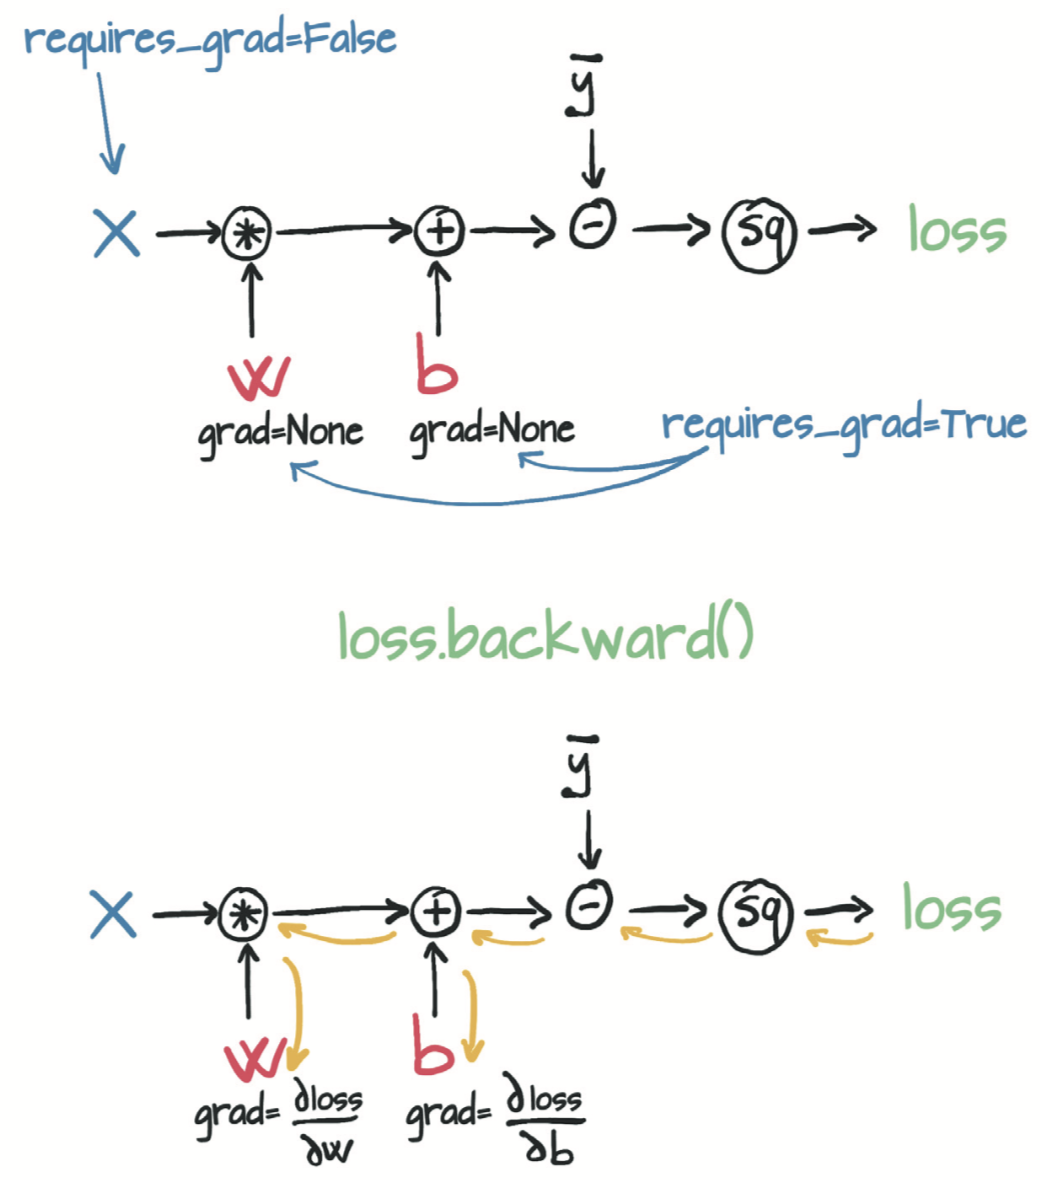

In [282]:
# 重复调用backward会导致导数在叶节点处累积.
    # 应该zero_方法清理这些累积的导数。
if params.grad is not None:
    params.grad.zero_()

### autograd重写循环训练代码

In [283]:
def training_loop(n_epochs,learning_rate,
                  params,t_u,t_c,verbose=500):
    for epochs in range(1,n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()  # 只要在backword调用之前，执行就可以。
        w,b = params
        t_p = model(t_u,w,b) # 向前传播,并追踪params及其子张量w,b
        loss = loss_fn(t_p, t_c) # 得到损失张量
        loss.backward() # 损失张量调用向后传播,得到params及其子张量的导数
        params = (params-learning_rate*params.grad).detach().requires_grad_()
            # 更新params 
        if epochs%verbose == 0:   # 打印
            print('Epoch %d ,Loss %f' % (epochs,float(loss)))
    return params 

请注意，**更新参数时,.detach().requires_grad_()**。要了解原因，请考虑一下你构建的计算图。为了避免重复使用变量名，我们重构params参数更新行：p1 = (p0 * lr * p0.grad)。这里p0是用于初始化模型的随机权重，p0.grad是通过损失函数根据p0和训练数据计算出来的。

到目前为止，一切都很好。现在，你需要**进行第二次迭代：p2 = (p1 * lr * p1.grad)。如你所见，p1的计算图会追踪到p0，这是有问题的**，因为(a)你需要将p0保留在内存中（直到训练完成），并且(b)在反向传播时不知道应该如何分配误差。

相反，**应该通过调用.detatch()将新的params张量从与其更新表达式关联的计算图中分离出来。这样，params就会丢失关于生成它的相关运算的记忆**。然后，你可以**调用.requires_grad_()，这是一个就地（in place）操作（注意下标“_”），以重新启用张量的自动求导**。现在，你可以释放旧版本params所占用的内存，并且只需通过当前权重进行反向传播。

#### 调用antograd重写的循环训练

In [284]:
t_un = (t_u - t_u.mean())/t_u.std() # 特征缩放

params = training_loop(n_epochs=5000,learning_rate=1e-3,
              params=params,t_u=t_un,t_c=t_c,verbose=500)


Epoch 500 ,Loss 27.423870
Epoch 1000 ,Loss 6.493824
Epoch 1500 ,Loss 3.451048
Epoch 2000 ,Loss 3.005103
Epoch 2500 ,Loss 2.939204
Epoch 3000 ,Loss 2.929383
Epoch 3500 ,Loss 2.927909
Epoch 4000 ,Loss 2.927685
Epoch 4500 ,Loss 2.927652
Epoch 5000 ,Loss 2.927647


---

---

### 4.2.1 优化器

我们将对梯度下降进行优化,存在几种优化策略和技巧可以帮助收敛。


torch模块有一个optim子模块，你可以在其中找到实现不同优化算法的类。

In [285]:
# 优化器清单
import torch.optim as optim
dir(optim)
    #   Adam是非常好的优化器。其结合AdaGrad和RMSProp两种优化算法的优点。

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']

- （A）优化器对参数的引用的概念表示，
- 然后（B）根据输入计算损失，
- （C）对backward的调用会将grad填充到参数内。
- 此时，（D）优化器可以访问grad并计算参数更新。

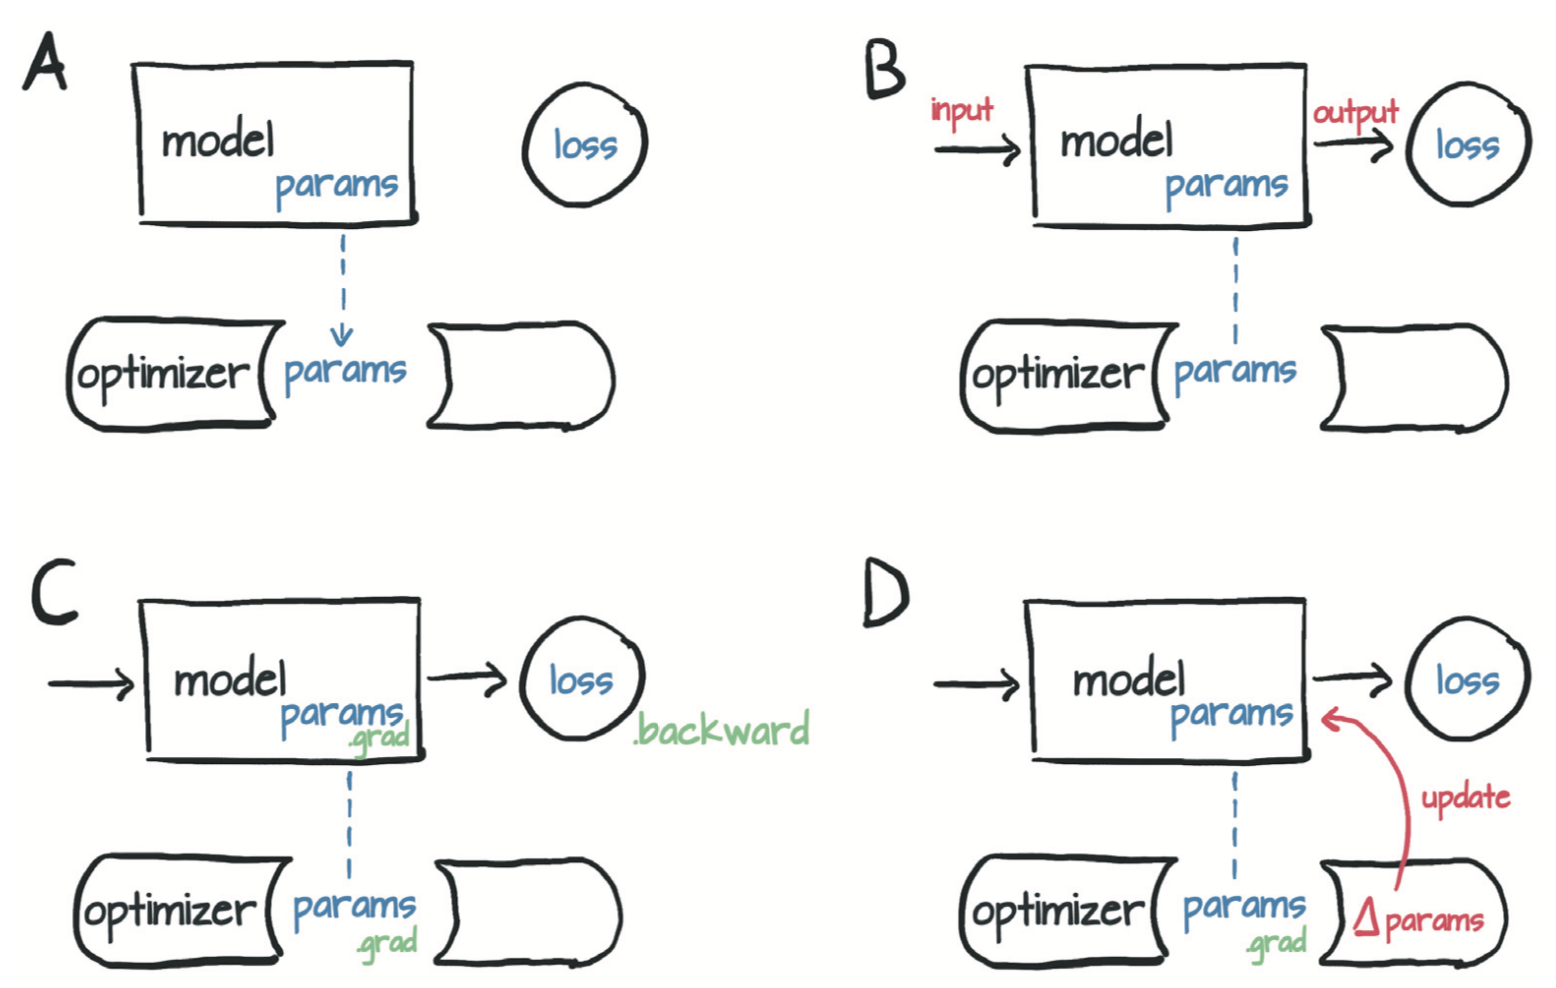

#### 使用Adam梯度下降优化器的训练循环代码

**每个优化器都有两个方法：zero_grad和step**。前者将构造时传递给优化器的所有参数的grad属性归零；后者根据特定优化器实施的优化策略更新这些参数的值。

##### 1 训练循环代码

In [298]:
def training_loop(n_epochs,optimizer,
                  params,t_u,t_c,verbose=500):
    for epoch in range(1,n_epochs+1):
        
        w,b = params
        t_p = model(t_u,w,b) # 向前传播，拿到预测张量
        loss = loss_fn(t_p,t_c) # 损失张量
        
        #if params.grad is not None:
        #    params.grad.zero_()   # 手动grad清零
        optimizer.zero_grad()   # 优化器grad清零
        loss.backward() # 向后传播
        optimizer.step()  # 优化器更新参数
        
        if epoch%verbose ==0 :
            print(" Epoch %d, Loss %f" % (epoch,float(loss)))
    return params

##### 2 创建参数并实例化一个梯度下降优化器

In [299]:
import torch.optim as optim

In [300]:
params = torch.tensor([1.,0.], requires_grad =True)
learning_rate = 1e-2
optimizer = optim.Adam([params],lr=learning_rate)
    # Adam是非常好的优化器。其结合AdaGrad和RMSProp两种优化算法的优点。
        # params参数 = [params] :need an iterable of Tensors or dicts
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

#### 3调用循环训练代码

In [301]:
training_loop(n_epochs=5000,optimizer=optimizer,
             params=params,t_u=t_u,t_c=t_c,verbose=500)

 Epoch 500, Loss 25.590321
 Epoch 1000, Loss 22.958570
 Epoch 1500, Loss 19.641722
 Epoch 2000, Loss 16.026125
 Epoch 2500, Loss 12.481906
 Epoch 3000, Loss 9.332459
 Epoch 3500, Loss 6.805130
 Epoch 4000, Loss 4.996398
 Epoch 4500, Loss 3.867489
 Epoch 5000, Loss 3.274242


tensor([  0.5017, -15.3177], requires_grad=True)

In [302]:
# 绘图
import matplotlib.pyplot as plt
%matplotlib inline

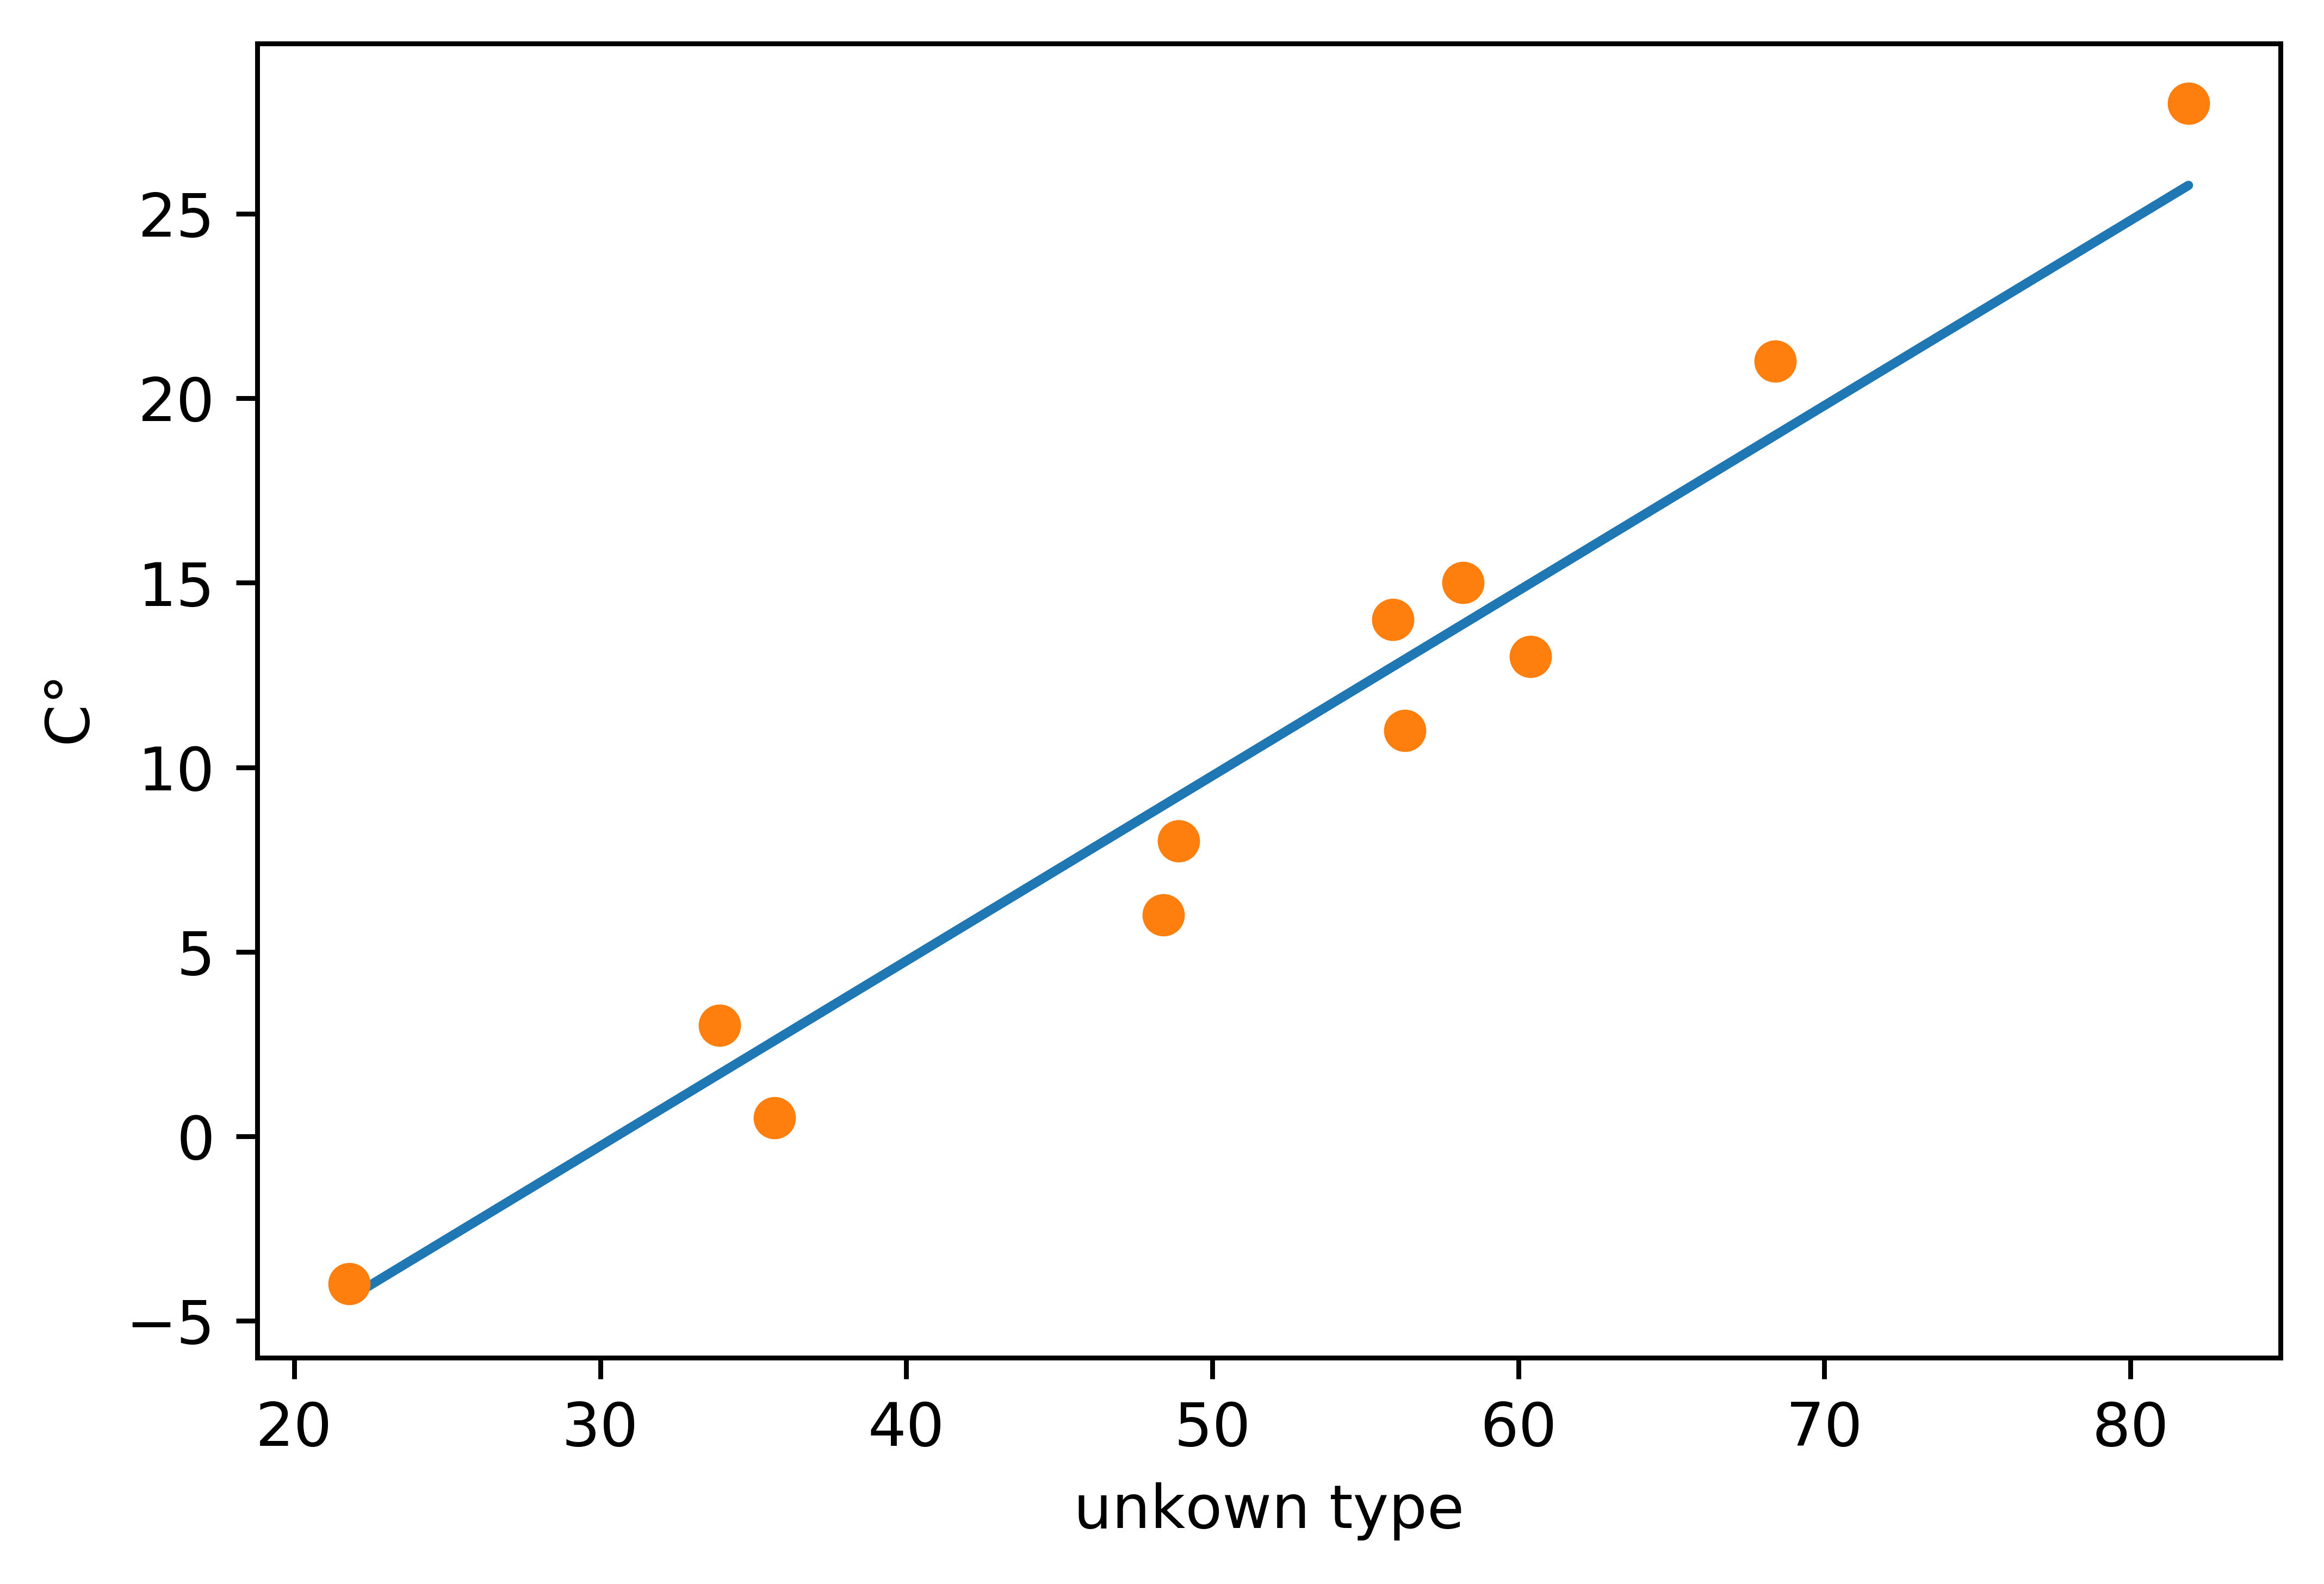

In [303]:
w,b = params
t_p = model(t_u,w,b)
plt.figure(dpi=800)
plt.xlabel('unkown type')
plt.ylabel('C° ')
plt.plot(t_u.numpy(),t_p.detach().numpy())
    # .detach() ?
        #  Can't call numpy() on Variable that requires grad. 
            # Use var.detach().numpy() instead.
plt.plot(t_u.numpy(),t_c.numpy(),'o')

### 4.2.2 训练、验证和过拟合

适应性强的模型倾向于使用其许多参数来确保在训练数据上的损失最小，但是你**无法保证该模型在远离训练数据或在训练数据之间的数据上表现良好**。

我们将其称为**过拟合（overfitting）**

---

数据产生过程以及训练数据和独立验证数据的收集和使用示意图

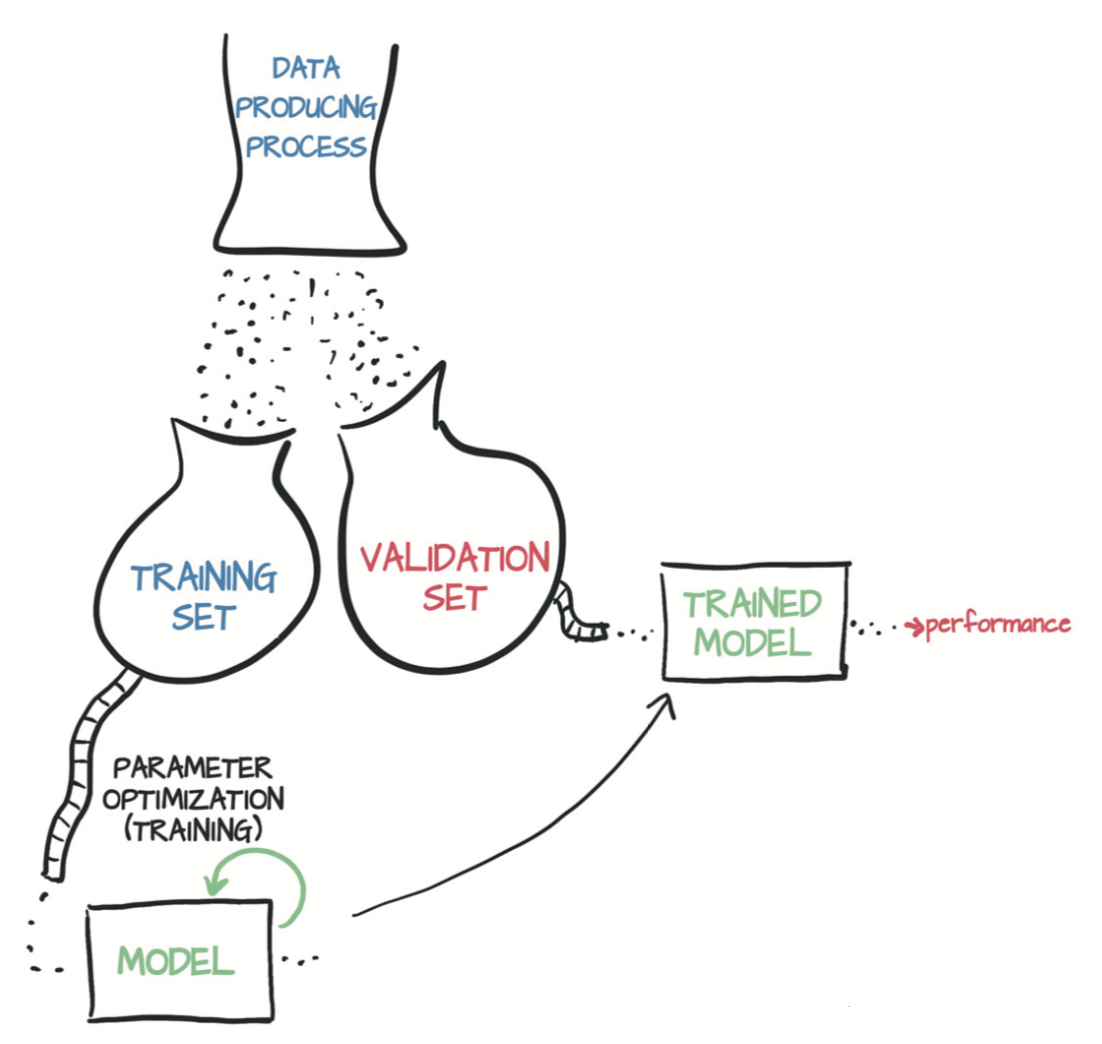

严重过拟合的例子

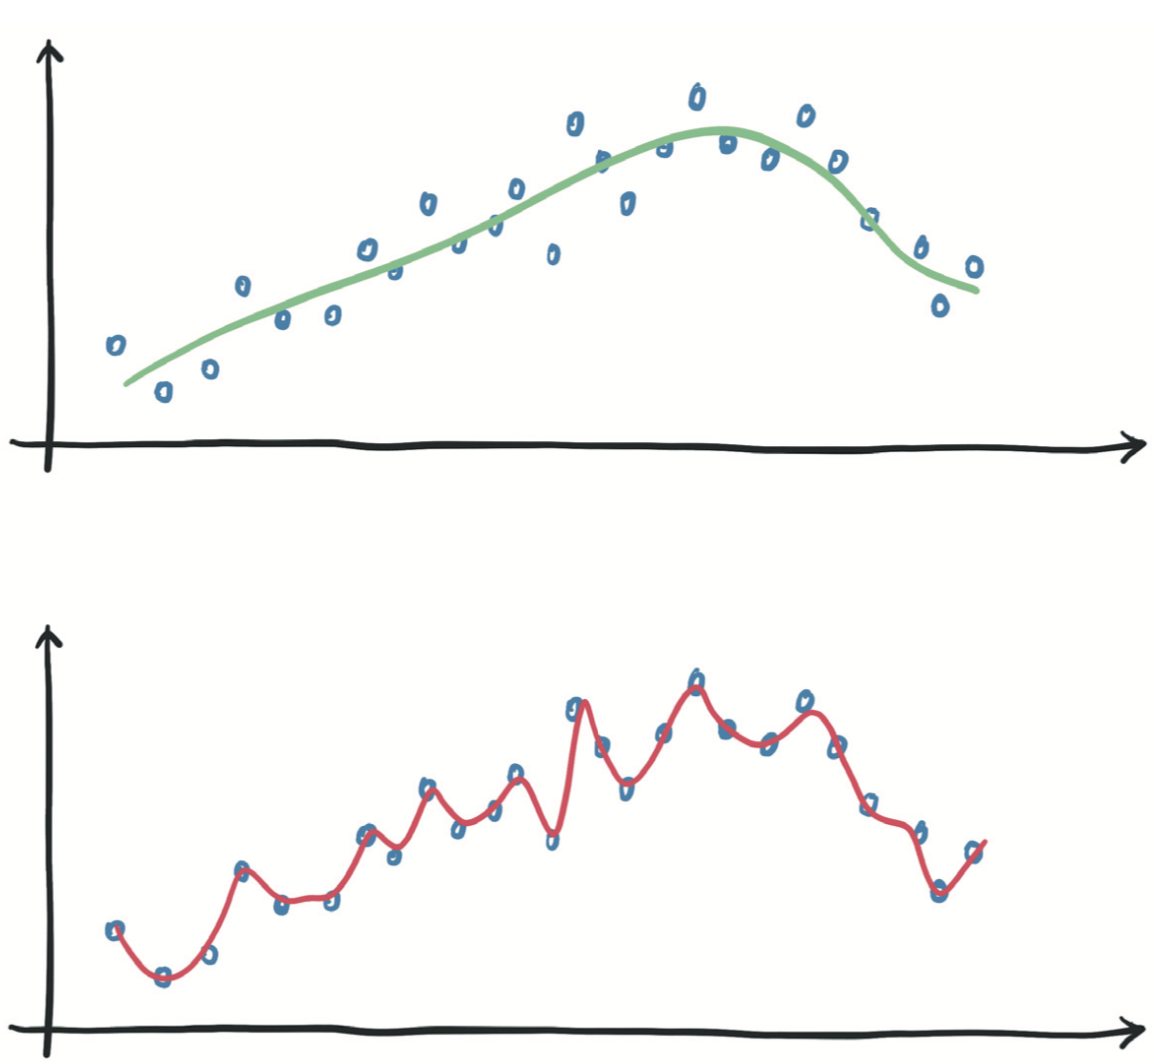

---

#### 有什么办法防止过拟合？
几种方法可以实现此目标：一种方法是**在损失函数中添加所谓的惩罚项**，以使模型的行为更平稳，变化更慢（到一定程度）；另一种方法是**向输入样本添加噪声**，在训练数据样本之间人为地创建新的数据，并迫使模型也尝试拟合它们。还有几种与这两种方法有些相关的方式。


你应该做的就是在拟合和过拟合之间的平衡。你可以通过以相同的方式对t_u和t_c进行打乱，然后**将生成的数据随机分为两部分从而得到训练集和验证集**。

张量的元素进行打乱等价于重新排列其索引。**randperm函数**完成了这个操作

In [304]:
# 测试
torch.randperm(10)

tensor([0, 2, 8, 4, 5, 7, 9, 3, 1, 6])

In [305]:
# 得到训练和验证样本的随机索引集
n_samples = t_u.shape[0]    # 得到全部样本数
n_val = int(0.2 * n_samples)  #设置验证集的样本数

shuffled_indices = torch.randperm(n_samples) 
train_indices = shuffled_indices[:-n_val]  # 训练样本的索引集
val_indices = shuffled_indices[-n_val:]   # 验证样本的索引集

train_indices, val_indices # 划分结果是随机的

(tensor([ 5,  6,  8, 10,  0,  1,  9,  2,  4]), tensor([3, 7]))

In [306]:
# 根据随机索引集得到随机的训练集和验证集
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
    # 训练集
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]
    # 验证集
train_t_un = (train_t_u - train_t_u.mean())/train_t_u.std()
val_t_un = (val_t_u - val_t_u.mean())/val_t_u.std()
    # 训练集和验证集的"X变量"特征放缩

In [307]:
# 循环训练函数
    # 训练循环代码和之前一样，额外添加了评估每个epoch的验证损失以便查看是否过度拟合
        ### 注意验证集只用于验证损失，并不用于学习(向后传播)
def training_loop(n_epochs,optimizer,
                  params,train_t_u,train_t_c,val_t_u,val_t_c,
                  verbose=500):
    for epoch in range(1,n_epochs+1):
        w,b =params
        
        train_t_p = model(train_t_u,w,b) # 向前传播，训练集预测张量
        train_loss = loss_fn(train_t_p,train_t_c)  # 训练集损失张量
        
        val_t_p = model(val_t_u,w,b) # 向前传播，验证集预测张量
        val_loss = loss_fn(val_t_p,val_t_c)  # 验证集损失张量
        
        optimizer.zero_grad()  # 优化器清零grad
        train_loss.backward() # 验证集向后传播。
            ### 注意没有val_loss.backward()因为不能在验证集上训练模型
        optimizer.step()  # 优化器更新参数

        if epoch % verbose ==0:
            print('Epoch %d, Training loss %.2f, Validation loss %.2f' % (
                        epoch, float(train_loss), float(val_loss)))
    return params

In [308]:
# 创建Adam优化器
params = torch.tensor([1.,0.],requires_grad = True) # 参数张量
optimizer =  torch.optim.Adam([params],lr=1e-1) 
    # Adam算法自适应学习率,所以学习率其实可以不写

In [309]:
# 调用循环训练
training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    params=params,
    train_t_u=train_t_un,
    train_t_c=train_t_c,
    val_t_u = val_t_un,
    val_t_c = val_t_c,
    verbose=500)

Epoch 500, Training loss 2.98, Validation loss 138.84
Epoch 1000, Training loss 2.98, Validation loss 138.84
Epoch 1500, Training loss 2.98, Validation loss 138.84
Epoch 2000, Training loss 2.98, Validation loss 138.84
Epoch 2500, Training loss 2.98, Validation loss 138.84
Epoch 3000, Training loss 2.98, Validation loss 138.84
Epoch 3500, Training loss 2.98, Validation loss 138.84
Epoch 4000, Training loss 2.98, Validation loss 138.84
Epoch 4500, Training loss 2.98, Validation loss 138.84
Epoch 5000, Training loss 2.98, Validation loss 138.84


tensor([ 6.1664, 10.1667], requires_grad=True)

---

我们对模型并不完全公平，因为验证集很小，所以验证损失仅在一定程度上有意义

尽管在理想情况下两个损失应该大致相等，即验证损失与训练损失很接近

---

训练（蓝色）和验证（红色）损失曲线图。
- （A）训练和验证损失没有下降；由于数据中没有信息或模型拟合能力不足，该模型无法学习。
- （B）训练损失下降而验证损失增加（过拟合）。
- （C）**训练和验证损失同步减少；由于模型并非处于过拟合的极限，因此性能可能会进一步提高。**
- （D）训练和验证损失具有不同的绝对值但趋势相似；过拟合在可控之内。

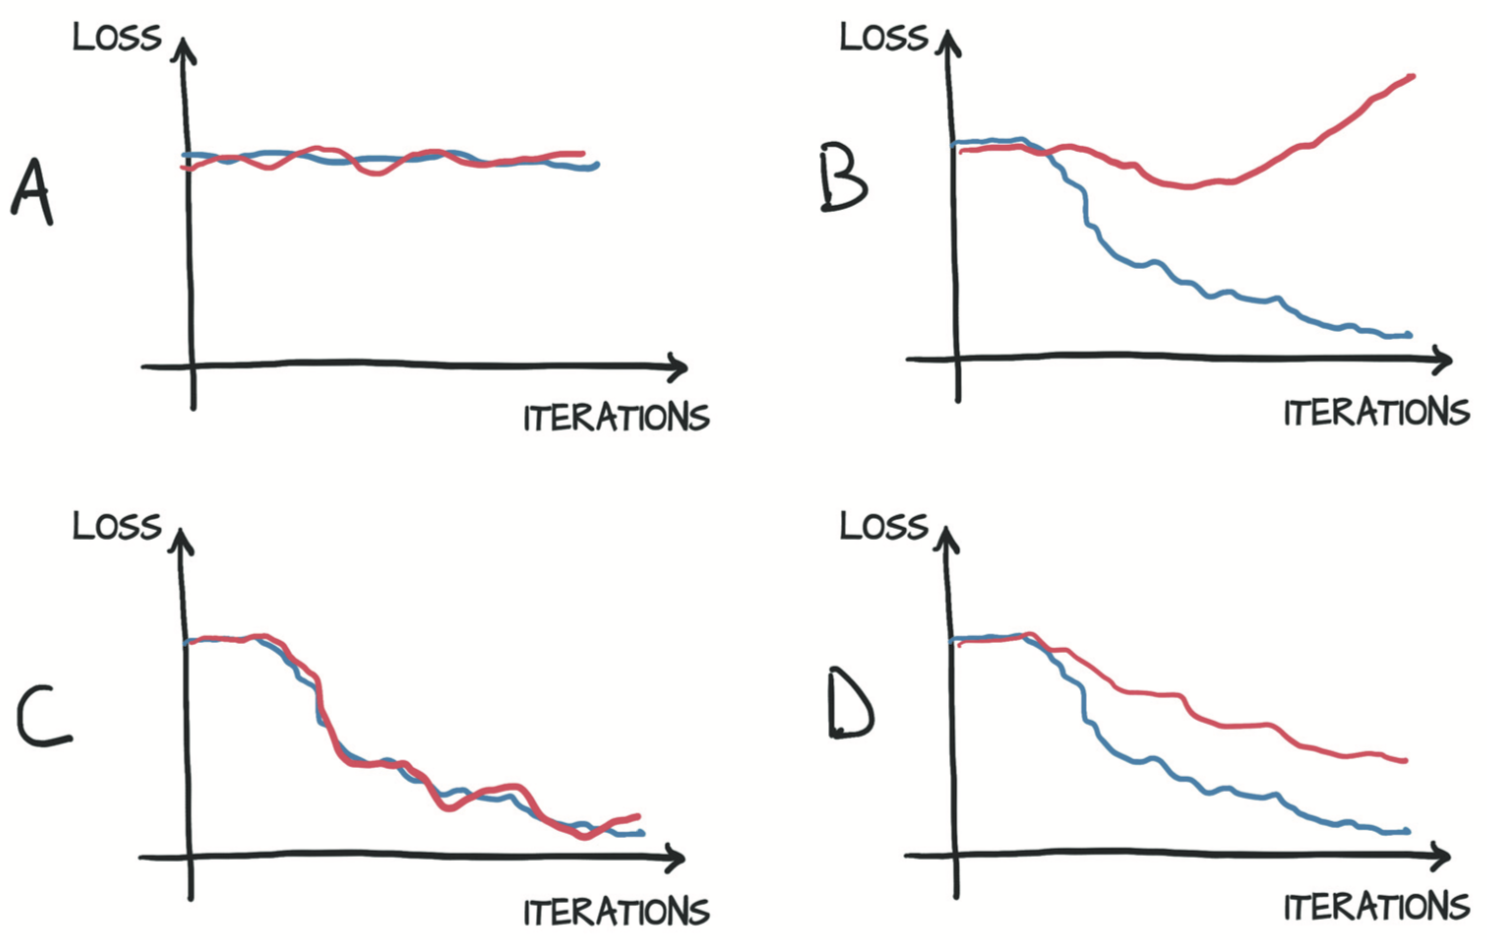

---

### 4.2.3 不需要时关闭autograd

从训练循环中，你注意到**只能在train_loss上调用backward。因此，误差只会根据训练集来进行反向传播。**

验证集用于在未用于训练的数据上**对模型输出的准确性进行独立的评估**。

---
#### 计算图：一次训练循环中的两次评估、一次向后传播

单独的张量通过相同的函数model和loss_fn运行，生成了**单独的计算图**。

但这些单独的计算图之间有个共同点————**相同的params**。所以如果你在验证集和训练集的损失张量上都调用了backward,那么这些grad会累积params中，很显然这是错误的。

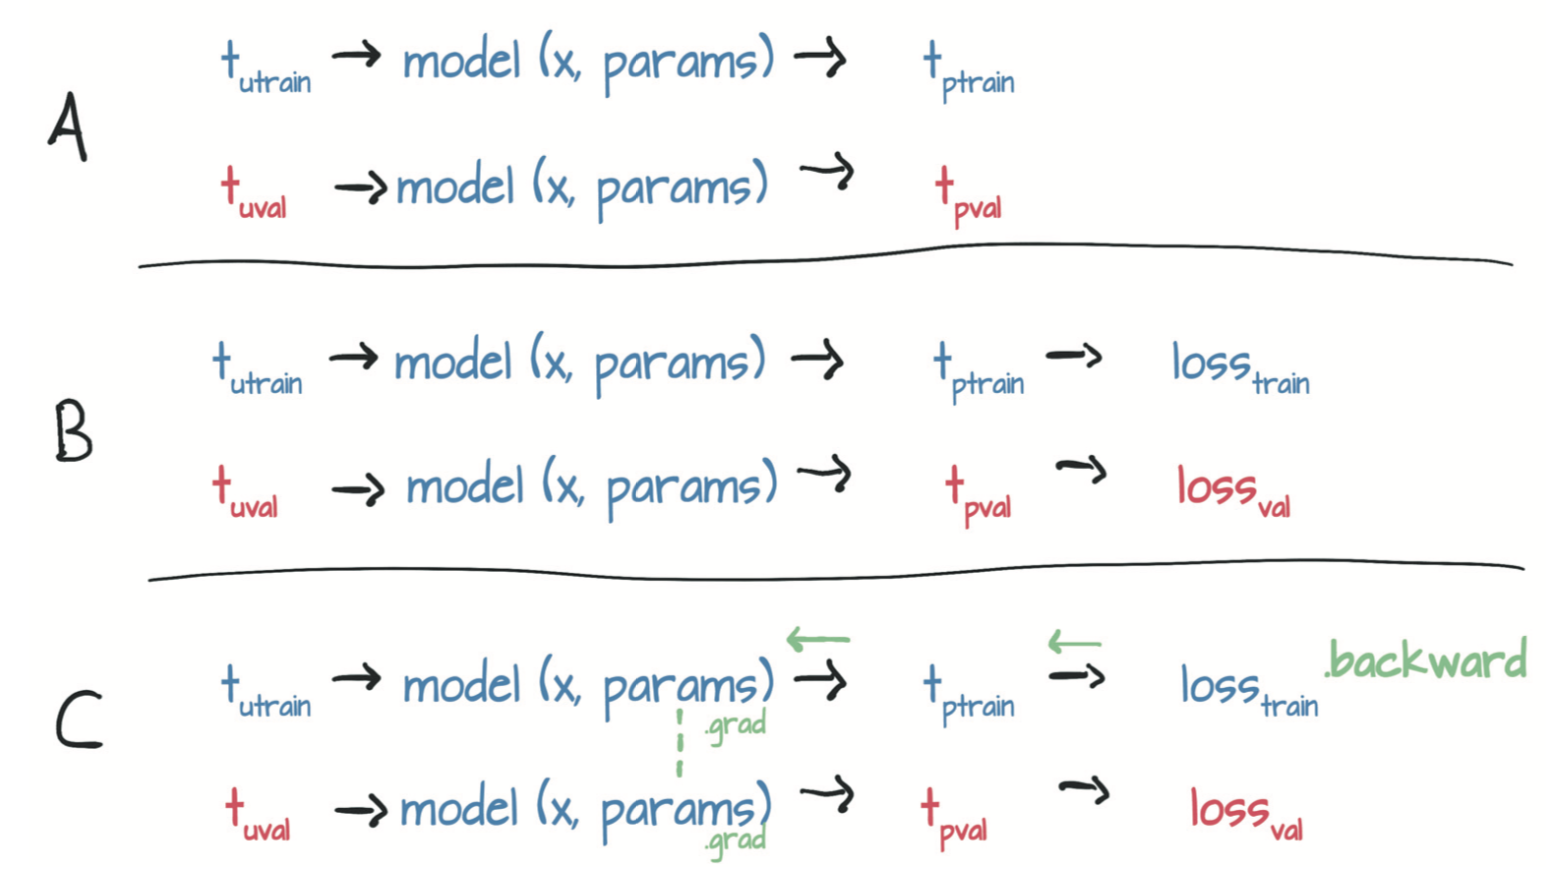

#### 使用torch.no_grad上下文管理器在不需要时关闭autograd
由于验证集损失张量不需要向后传播，所以关闭验证集相关的追踪计算,所以关闭其autograd。

#### 版本1

In [315]:
def training_loop(n_epochs, optimizer, params, 
                  train_t_u, val_t_u, train_t_c, val_t_c,
                  verbose=500):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params) #向前传播，预测张量
        train_loss = loss_fn(train_t_p, train_t_c) # 损失张量
        
        with torch.no_grad():     
                # Context-manager that disabled gradient calculation.
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
                # 使用torch.no_grad上下文管理器在不需要时关闭autograd

        optimizer.zero_grad()  #优化器清零grad
        train_loss.backward()  #训练损失张量调用向后传播
        optimizer.step()   # 优化器更新权置参数
        
        if epoch % verbose ==0:
            print('Epoch %d, Training loss %.2f, Validation loss %.2f' % (
                        epoch, float(train_loss), float(val_loss)))
    return params    

#### 版本2(建议)

In [319]:
# 这是上述 with torch.no_grad() 的替代方案。

    # is_train = True 则带autograd返回loss损失张量
    # is_train = False 则不带autograd返回loss损失张量
def calc_forward(t_u, t_c, params,is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss


def training_loop(n_epochs, optimizer, params, 
                  train_t_u, val_t_u, train_t_c, val_t_c,
                  verbose=500):
    for epoch in range(1, n_epochs + 1):
        
        train_loss = calc_forward(train_t_u,train_t_c,params,True)
        val_loss = calc_forward(val_t_u,val_t_c,params,False)
        
        optimizer.zero_grad()  #优化器清零grad
        train_loss.backward()  #训练损失张量调用向后传播
        optimizer.step()   # 优化器更新权置参数
        
        if epoch % verbose ==0:
            print('Epoch %d, Training loss %.2f, Validation loss %.2f' % (
                        epoch, float(train_loss), float(val_loss)))
    return params    

---

In [320]:
# 测试
training_loop(n_epochs=5000,optimizer=optimizer,params=params,
              train_t_u=train_t_un,
              train_t_c=train_t_c,
              val_t_u = val_t_un,
              val_t_c = val_t_c,
              verbose=500)

Epoch 500, Training loss 2.98, Validation loss 138.84
Epoch 1000, Training loss 2.98, Validation loss 138.84
Epoch 1500, Training loss 2.98, Validation loss 138.84
Epoch 2000, Training loss 2.98, Validation loss 138.84
Epoch 2500, Training loss 2.98, Validation loss 138.84
Epoch 3000, Training loss 2.98, Validation loss 138.84
Epoch 3500, Training loss 2.98, Validation loss 138.81
Epoch 4000, Training loss 2.98, Validation loss 138.83
Epoch 4500, Training loss 2.98, Validation loss 138.84
Epoch 5000, Training loss 2.98, Validation loss 138.85


tensor([ 6.1659, 10.1737], requires_grad=True)

---